Загрузка RuBERT

Импорты и конфигурация

In [19]:
# Работа с файлами и путями
import os
import re
import random
from collections import defaultdict
from collections import Counter

# Torch и модель
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Transformers (Hugging Face)
from transformers import AutoTokenizer, AutoModel

# Визуализация и метрики
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Прогресс-бар
from tqdm.notebook import tqdm

# Работа с табличками
import pandas as pd

# Пути и модель
local_model_path = "models/rubert"
model_name = "DeepPavlov/rubert-base-cased"
author_folder = "data/"  
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Проверка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cuda


Загрузка текстов всех авторов

In [20]:
def read_all_authors_texts(data_dir, max_samples_per_author=500, min_len=50, max_len=300):
    texts = []
    labels = []

    for fname in sorted(os.listdir(data_dir)):
        if fname.endswith(".txt") and not fname.startswith("author"):
            author = fname.replace(".txt", "")
            with open(os.path.join(data_dir, fname), 'r', encoding='utf-8') as f:
                raw = f.read().lower()

            # Чистим текст: только буквы, пробелы, точки
            raw = re.sub(r'[^а-яa-zё\s.]', ' ', raw)
            raw = raw.replace('ё', 'е')
            raw = re.sub(r'\s+', ' ', raw)

            # Разбиваем на фрагменты по точкам
            fragments = [frag.strip() for frag in raw.split('.') if min_len < len(frag) < max_len]

            # Ограничим количество на автора
            fragments = fragments[:max_samples_per_author]

            texts.extend(fragments)
            labels.extend([author] * len(fragments))

    return texts, labels


In [21]:
texts, labels = read_all_authors_texts(author_folder, max_samples_per_author=1000)
print(f"Всего фрагментов: {len(texts)}")
print("Пример:", texts[0])

Всего фрагментов: 6000
Пример: по фаренгейту дону конгдону с благодарностью если тебе дадут линованную бумагу пиши поперек


LabelEncoder и разделение на train/val

In [22]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Проверим соответствие меток
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

0: Bradbury
1: Bulgakov
2: Fry
3: Genri
4: Simak
5: Strugatskie


In [23]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    encoded_labels,
    test_size=0.2,
    stratify=encoded_labels,
    random_state=42
)

print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}")
print("Train class distribution:", Counter(train_labels))
print("Val class distribution:", Counter(val_labels))


Train size: 4800, Validation size: 1200
Train class distribution: Counter({0: 800, 5: 800, 1: 800, 4: 800, 2: 800, 3: 800})
Val class distribution: Counter({3: 200, 2: 200, 0: 200, 1: 200, 5: 200, 4: 200})


Токенизация текстов

In [24]:
def tokenize_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        texts,
        padding=True,         # добавляет паддинг до max_len
        truncation=True,      # обрезает, если длиннее max_len
        max_length=max_len,   # фиксируем длину (BERT ограничен)
        return_tensors='pt'   # PyTorch-совместимый формат
    )



In [26]:
train_encodings = tokenize_texts(train_texts, tokenizer)
val_encodings = tokenize_texts(val_texts, tokenizer)

Dataset-класс и DataLoader

In [27]:
class BertTextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


In [29]:
train_dataset = BertTextDataset(train_encodings, train_labels)
val_dataset = BertTextDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Создаем класс модели

In [31]:
class BertClassifier(nn.Module):
    def __init__(self, model_name, num_classes, dropout=0.3):
        super(BertClassifier, self).__init__()

        # Загружаем предобученную модель
        self.bert = AutoModel.from_pretrained(model_name)

        # Dropout для регуляризации
        self.dropout = nn.Dropout(dropout)

        # Линейный слой: [CLS]-вектор (768) → классы (6)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Получаем скрытые представления от BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Используем [CLS]-вектор (первый токен) как "сжатое представление смысла"
        cls_output = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

        x = self.dropout(cls_output)
        logits = self.classifier(x)
        return logits


In [32]:
num_classes = len(label_encoder.classes_)

model = BertClassifier(model_name=model_name, num_classes=num_classes)
model.to(device)


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

Обучение и валидация модели

In [34]:
"""Оценка модели на валидационной выборке (без обучения) """

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


In [35]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

        train_acc = correct / total
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1} — Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [36]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.show()


Epoch 1:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1 — Train Loss: 190.7794, Train Acc: 0.5038, Val Acc: 0.6558


Epoch 2:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 2 — Train Loss: 95.4890, Train Acc: 0.7773, Val Acc: 0.7500


Epoch 3:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 3 — Train Loss: 44.6234, Train Acc: 0.9023, Val Acc: 0.7783


Epoch 4:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 4 — Train Loss: 20.8689, Train Acc: 0.9569, Val Acc: 0.7642


Epoch 5:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 5 — Train Loss: 10.3469, Train Acc: 0.9794, Val Acc: 0.7767


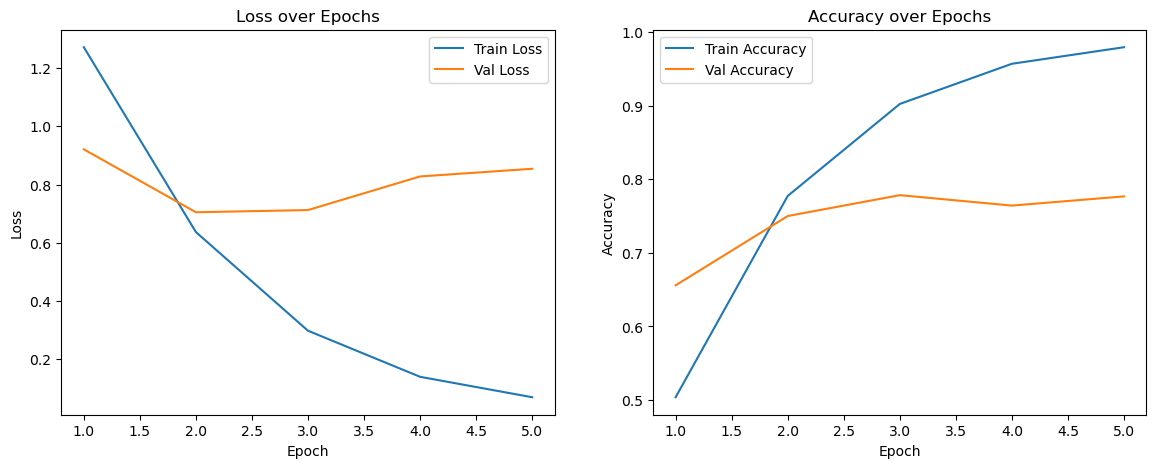

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, criterion, epochs=5
)

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


Получаем все предсказания модели на валидационном датасете

In [38]:
# Получаем все предсказания модели на валидационном датасете
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels


Отчеты

Classification Report:
              precision    recall  f1-score   support

    Bradbury       0.75      0.70      0.73       200
    Bulgakov       0.90      0.83      0.86       200
         Fry       0.74      0.82      0.78       200
       Genri       0.80      0.80      0.80       200
       Simak       0.73      0.68      0.70       200
 Strugatskie       0.75      0.82      0.78       200

    accuracy                           0.78      1200
   macro avg       0.78      0.78      0.78      1200
weighted avg       0.78      0.78      0.78      1200



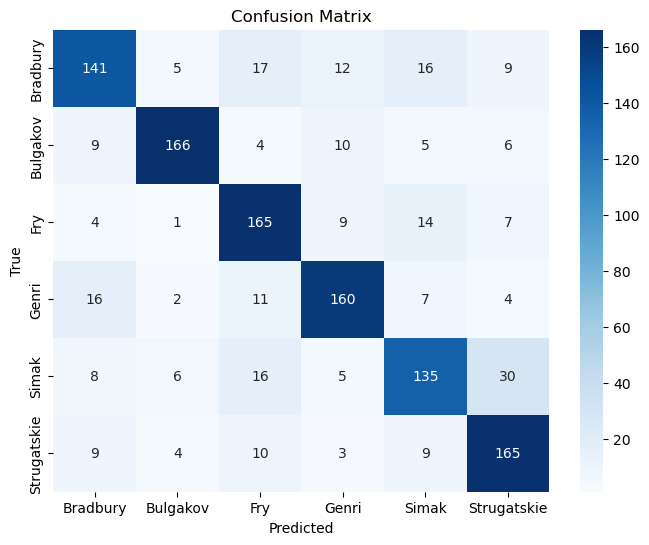

In [39]:
# Получаем предсказания и метки
y_pred, y_true = get_predictions(model, val_loader)

# Строим classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Строим confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Создание submission.csv

In [40]:
def load_test_texts(folder_path):
    test_texts = []
    file_names = []

    for fname in sorted(os.listdir(folder_path)):
        if fname.startswith("author") and fname.endswith(".txt"):
            with open(os.path.join(folder_path, fname), encoding='utf-8') as f:
                text = f.read().strip()
                test_texts.append(text)
                file_names.append(fname.replace(".txt", ""))
    return file_names, test_texts

def predict_author_bert(texts, model, tokenizer, max_len=256):
    model.eval()
    results = []

    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(
                text,
                padding='max_length',
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            output = model(input_ids, attention_mask)
            pred = torch.argmax(output, dim=1).item()
            results.append(pred)

    return results

# Загружаем тексты
test_path = "data/"
file_ids, test_texts = load_test_texts(test_path)

# Предсказания
test_preds = predict_author_bert(test_texts, model, tokenizer)

# Обратное преобразование индексов в имена авторов
predicted_labels = label_encoder.inverse_transform(test_preds)

# Создание submission-файла
submission = pd.DataFrame({
    "id": file_ids,
    "label": predicted_labels
})
submission.to_csv("submission_BERT.csv", index=False)
submission.head()


,id,label
0,author1,Genri
1,author10,Bradbury
2,author11,Bulgakov
3,author12,Strugatskie
4,author13,Genri
